### 0. 필요한 라이브러리 Import

In [1]:
import os
import pandas as pd
import pandas_profiling
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from gensim.models.word2vec import Word2Vec
import nltk
import time
from pykospacing import spacing
import re

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

import kss
#from konlpy.tag import Kkma  
from konlpy.tag import Twitter
from eunjeon import Mecab
from konlpy.tag import Okt

# %appdata%\nltk_data\corpora\stopwords
# korean 파일을 생성하여 복사함
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

#nltk.download('stopwords')

np.random.seed(42)

twitter = Twitter()
#kkma = Kkma()
mecab = Mecab('C://mecab//mecabrc')
okt = Okt()


# 한글출력
#matplotlib.rc('font', family='AppleGothic')  # MacOS
matplotlib.rc('font', family='Malgun Gothic')  # Windows
plt.rcParams['axes.unicode_minus'] = False

### 1. 통합된 원본 데이터 파일을 읽어온다

In [23]:
ROOT_DIR = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
dataset = pd.read_csv(os.path.join(ROOT_DIR, "dataset/one.csv"))

print(dataset.shape)
print(dataset.info())

(50568, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50568 entries, 0 to 50567
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   제목                              50568 non-null  object 
 1   저자                              50568 non-null  object 
 2   발행기관                            50568 non-null  object 
 3   학술지명                            50568 non-null  object 
 4   권호사항                            50568 non-null  object 
 5   발행연도                            50568 non-null  int64  
 6   작성언어                            50568 non-null  object 
 7   주제어                             26933 non-null  object 
 8   KDC                             11761 non-null  float64
 9   등재정보                            13083 non-null  object 
 10  자료형태                            50568 non-null  object 
 11  발행기관 URL                        22715 non-null  object 
 12  수록면                 

In [24]:
dataset.head()

,제목,저자,발행기관,학술지명,권호사항,발행연도,작성언어,주제어,KDC,등재정보,...,발행기관 URL,수록면,KCI 피인용횟수,비고,중단사유,제공처,소장기관,국문 초록 (Abstract),다국어 초록 (Multilingual Abstract),목차
0,전기 이륜자동차 분류기준 현황 : 자동차관리법 중심,정윤재,한국자동차공학회,한국자동차공학회 Workshop,Vol.2011No.9[2011]\r\n,2011,Korean,NaN,556.0,NaN,...,http://www.ksae.org,1-14,NaN,NaN,NaN,DBpia,NaN,NaN,NaN,NaN
1,자동차 사회의 환경과 에너지 문제 = 자동차 엔진 기술의 역사적 동향,김영길(Yong Kil Kim),한국자동차공학회,한국자동차공학회 학술대회 및 전시회,Vol.2014No.11[2014]\r\n,2014,Korean,"Internal Combustion Engine(내연기관),Energy (에너지),...",NaN,NaN,...,NaN,1477-1477,NaN,NaN,NaN,DBpia,NaN,NaN,NaN,NaN
2,수소 연료전지 자동차의 충돌 및 화재안전성 관련 연구동향 = Trends on Cr...,"임재문(Jae Moon Lim),장형진(Hyung Jin Chang),김규현(Gyu...",한국자동차공학회,한국자동차공학회 춘 추계 학술대회 논문집,Vol.-No.-[2008]\r\n,2008,Korean,"Hydrogen Fuel Cell Vehicle(수소 연료전지 자동차),Crash ...",NaN,NaN,...,http://www.ksae.org,1253-1258,NaN,NaN,NaN,DBpia,NaN,환경문제에 따른 배기가스 배출저감 및 자원고갈에 따른 대안으로 향후 수소 연료전지 ...,The researches on the crash and the fire safet...,Abstract\n1. 서론\n2. 수소의 특성\n3. 충돌 및 화재안전성 관련 연...
3,차세대 자동차 개발의 Plastic Hood 설계 및 CAE해석 = Plastic ...,"황태원(Taewon Hwang),최치훈(Chihoon Choi),박상선(Sangsu...",한국자동차공학회,한국자동차공학회 춘 추계 학술대회 논문집,Vol.-No.-[2006]\r\n,2006,Korean,"HOOD(본넷트),Distance(이동량),LS-DYNA(구조해석),MOLDFLOW...",NaN,NaN,...,http://www.ksae.org,2032-2032,NaN,NaN,NaN,DBpia,NaN,현재 생활 필수품 중의 하나인 자동차논 많은 변화를 보이고 있다. 발전사를 살펴보면...,NaN,NaN
4,자동차 산업의 역사와 급변하는 기술에 대응한 교육의 바람직한 방향에 관한 연구 = ...,황경수(Kyungsoo Whang),한국자동차공학회,한국자동차공학회 Workshop,Vol.2001No.-[2001]\r\n,2001,Korean,NaN,NaN,NaN,...,http://www.ksae.org,70-80,NaN,NaN,NaN,DBpia,NaN,오늘날 급속히 변화하고 있는 자동차 기술에 대응한 자동차 기술교육의 방법을 모색하여...,NaN,초록<br/>\n1.서론<br/>\n2.국내 자동차기술교육의 역사<br/>\n3.민...


In [27]:
start = time.time()

train_data = dataset['국문 초록 (Abstract)'].dropna()
#train_data = train_data.apply(lambda x: re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣] ", "", x))

end = time.time()
print(f'총 소요시간:{end-start}초')

총 소요시간:0.003962278366088867초


In [28]:

print(len(train_data))

10447


사용 가능한 패키지
Soyspacing – https://github.com/lovit/soyspacing : 휴리스틱 알고리즘 기반 띄어쓰기 모델. 주어진 알고리즘으로 input으로 들어간 문장들에서 띄어쓰기 규칙을 파악하고 이를 새로운 문장에 적용. 모든 한글 문서에 광범위하게 적용할 수 있는 모델을 내기에는 한계가 있겠지만, 동질적인 주제와 형식을 가진 문서들에 대해 분석을 하는 경우 특히 유용하게 쓸 수 있을 것 같다. (특정 도메인을 위한 모델)

PyKoSpacing – https://github.com/haven-jeon/PyKoSpacing : CNN에 RNN을 쌓아 올린 모델을 뉴스 데이터로 훈련. 세종 코퍼스 등 테스트 셋에서 잘 작동한다고 한다. 하지만 accuracy measure가 성능을 over represent 할 수 있을 것 같다. 대체로 띄어쓰기가 정말 난장판으로 되어있는 경우 볼만한 문서로 바꾸는데 사용할 수 있을 것 같다.

TaKos (Alpha) – https://github.com/Taekyoon/takos-alpha : 앞서 첨부한 Youtube 영상에서 소개된 프로젝트. 아직 상용화까지 개발이 진행 중인 것 같다!

In [39]:
stop_words = stopwords.words('korean') + stopwords.words('english')
len(stop_words)

319

In [40]:
tokenized_data = []

start = time.time()
for abstract in train_data.tolist() :
    temp_X = mecab.morphs(abstract)
    temp_X = [word for word in temp_X if not word in stop_words]
    tokenized_data.append(temp_X)

end = time.time()
print(f'총 소요시간:{end-start}초')

총 소요시간:27.829155683517456초


초록의 최대 길이: 7463
초록의 평균 길이: 247.04259596056283


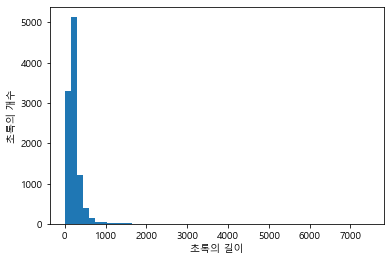

In [41]:
print('초록의 최대 길이:', max(len(l) for l in tokenized_data))
print('초록의 평균 길이:', sum(map(len, tokenized_data)) / len(tokenized_data))

plt.hist([len(s) for s in tokenized_data], bins=50)
plt.xlabel('초록의 길이')
plt.ylabel('초록의 개수')
plt.show()

In [42]:
model = Word2Vec(sentences=tokenized_data, size=100, window=5, min_count=5, workers=4, sg=0)

In [43]:
model.wv.vectors.shape

(20748, 100)

In [44]:
print(model.wv.most_similar("자율 주행"))

[('무인자동차', 0.8477469086647034), ('자율 주행 자동차', 0.8154755234718323), ('스마트 자동차', 0.8099040985107422), ('지능형 자동차', 0.8063652515411377), ('텔레매틱스', 0.7907307147979736), ('무선 네트워크', 0.7882574796676636), ('무인 자동차', 0.7875741720199585), ('핵심 기술', 0.7829225659370422), ('로봇청소기', 0.7819633483886719), ('커넥티드카', 0.7811912298202515)]


In [45]:
print(model.wv.most_similar("자율주행"))

[('자율주행 자동차', 0.844761073589325), ('자율주행자동차', 0.7767409086227417), ('보안', 0.7759484052658081), ('지능형 자동차', 0.7436614632606506), ('인공지능', 0.7420451641082764), ('자율주행차', 0.7340500950813293), ('무인자동차', 0.7233840227127075), ('자율 주행 자동차', 0.7059358358383179), ('내비게이션', 0.6978896856307983), ('소프트웨어', 0.6951377391815186)]


In [46]:
print(model.wv.most_similar("하이브리드"))

[('하이브리드 자동차', 0.914031982421875), ('LED', 0.8689936399459839), ('경량', 0.8583250045776367), ('차량용', 0.8559266328811646), ('자동차용', 0.8485767841339111), ('광원', 0.8450239896774292), ('연료전지', 0.843991756439209), ('고효율', 0.8422979712486267), ('파워', 0.8373817801475525), ('전기 자동차', 0.8337521553039551)]


### CountVector를 위한 준비 작업 및 확인 로직 (시작)

In [47]:
#분석대상 항목으로 발행연도, 제목, 주제어, 국문 초록 (Abstract)을 선택하고 컬럼명을 영문으로 변경함
dataset_1 = dataset.loc[:, ['발행연도', '제목', '저자', '발행기관', '학술지명', '주제어', '국문 초록 (Abstract)', '다국어 초록 (Multilingual Abstract)']]
dataset_1 = dataset_1.rename({'발행연도':'year', '제목':'title', '저자':'author', '발행기관':'publisher', '학술지명':'journal', '주제어':'keyword', '국문 초록 (Abstract)':'abstract_old', '다국어 초록 (Multilingual Abstract)':'others'}, axis=1)

In [48]:
dataset_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50568 entries, 0 to 50567
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   year          50568 non-null  int64 
 1   title         50568 non-null  object
 2   author        50568 non-null  object
 3   publisher     50568 non-null  object
 4   journal       50568 non-null  object
 5   keyword       26933 non-null  object
 6   abstract_old  10447 non-null  object
 7   others        25062 non-null  object
dtypes: int64(1), object(7)
memory usage: 3.1+ MB


In [ ]:
#국문 초록 값이 없는 건수가 전체의 80%에 해당하고 있음(잘못된 논리임)
#하지만 제목은 초록의 함축적인 문장으로 볼 수 있기 때문에 초록이 없는 경우 제목으로 대체


#0.주제어 예측
#1.가짜 키워드~ 판별....
#2.문서요약
#-키워드 백터
# dataset_2['keyword'].apply(get_words)
dataset_1['abstract'] = np.where(dataset_1['abstract_old'].isnull(), dataset_1['others'], dataset_1['abstract_old'])
#dataset_1['abstract'] = np.where(dataset_1['abstract_old'].isnull(), dataset_1['others'].apply(translate_test), dataset_1['abstract_old'])

del dataset_1['abstract_old']
del dataset_1['others']

dataset_1.info()

In [ ]:
dataset_2 = dataset_1[dataset_1['abstract'].isnull() == False]

In [ ]:
dataset_2.info()

In [49]:
#색인 추출
def tokenizer_by_twitter(raw, pos=["Noun","Alpha","Verb","Number"], stopword=stop_words):
    return [
        word for word, tag in twitter.pos(
            raw, 
            norm=True,   # normalize 그랰ㅋㅋ -> 그래ㅋㅋ
            stem=True    # stemming 바뀌나->바뀌다
            )
            if len(word) > 1 and tag in pos and word not in stopword
    ]
 
#색인 추출
def tokenizer_by_kkma(raw, pos=["NNG","NNP","NP", "VV"], stopword=stop_words):
    return [
        word for word, tag in kkma.pos(raw)
            if len(word) > 1 and tag in pos and word not in stopword
    ]

#색인 추출
def tokenizer_by_mecab(raw, pos=["NNG","NNP"], stopword=stop_words):
    return [
        word for word, tag in mecab.pos(raw)
            if len(word) > 1 and tag in pos and word not in stopword
    ]

In [50]:
dataset_2 = dataset_1[dataset_1['keyword'].isna() == False]
dataset_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26933 entries, 1 to 50566
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   year          26933 non-null  int64 
 1   title         26933 non-null  object
 2   author        26933 non-null  object
 3   publisher     26933 non-null  object
 4   journal       26933 non-null  object
 5   keyword       26933 non-null  object
 6   abstract_old  7526 non-null   object
 7   others        17411 non-null  object
dtypes: int64(1), object(7)
memory usage: 1.8+ MB


In [51]:
#2018년 이후 논문
dataset_3 = dataset_2[dataset_2['year'] >= 2018]
#dataset_3["keyword"] = dataset_3["keyword"].apply(lambda x: re.sub("[^ ㄱ-ㅎㅏ-ㅣ가-힣]+", " ", x).strip())
#인덱스 reset
#dataset_3 = dataset_3.reset_index()
rawdata = dataset_3['keyword'].tolist()

In [52]:
print(len(rawdata))
rawdata

5261


지),fault classification (고장분류),lifetime prediction (수명예측),condition based maintenance (상태기반정비)',
 'Electric oil pump,Noise,Uneven pitch,Transmission,Electric motor,전동식 오일 펌프,소음,부등 피치,변속기,전동기',
 'Engine control module(ECM, 엔진 제어 장치),Vehicle communication interface module(VCI, 차량 통신 인터페이스 모듈),Standardization(표준화),Common rail direct injection(CRDI, 커먼 레일 직분사 장치),Exhaust gas recirculation(EGR, 배기가스 재순환 장치)',
 'Mild hybrid electric vehicle(마일드 하이브리드차),48V System(48V 시스템),Belt driven Starter Generator(BSG),4 Wheel drive(4륜 구동),Fuel efficiency(연비 효율)',
 '토폴로지,인버터,양방향 충전,초소형 전기 구동장치,통합,Topology,Inverter,Bidirectional charging,Micro EV,Integration',
 'Micro-mobility(초소형 전기차),VCU(차량제어기),HILS(실시간 시뮬레이션)',
 '에스이오오씨,기능 안전,사용 사례,가정,가정된 안전 요구사항,기술안전요구사항,하드웨어 안전요구사항,사용의 가정,아키텍처,SEooC,ISO 26262 functional safety,Use case,Assumption,Assumed safety requirement,TSR,HSR,AoU,Architecture',
 '승차감 지수,진동 요소,선형회귀,인간요소,객관평가,과도 진동,Ride quality index,Vibration metrics,Linear regress,Human factor,Objective evaluati

In [53]:
import time
start = time.time()

vect = CountVectorizer(max_features = 300, max_df=0.95, min_df=10, tokenizer=tokenizer_by_mecab, ngram_range = (1, 3))
result = vect.fit_transform(rawdata)
print(
    'fit_transform, (sentence {}, feature {})'.format(result.shape[0], result.shape[1])
)

end = time.time()
print(f'총 소요시간: {end-start}초')

fit_transform, (sentence 5261, feature 158)
총 소요시간: 0.7629950046539307초


In [ ]:
data_array = result.toarray()
data = pd.DataFrame(data_array, columns= vect.get_feature_names())
data.shape

In [ ]:
data_array.T.shape

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, n_iter=10000, verbose=1)

In [ ]:
Z = tsne.fit_transform(data_array.T)

In [ ]:
plt.figure(figsize=(20, 20))
plt.scatter(Z[:,0], Z[:,1])

#점에 text 붙히기
for i in range(len(vect.get_feature_names())):
    plt.annotate(s=vect.get_feature_names()[i].encode("utf8").decode("utf8"), xy=(Z[i,0], Z[i,1]))
plt.draw()
plt.savefig('tsne.png', dpi=300)

In [ ]:
#수식이 필요함
#기관, 사람 도메인의 내용을 가지고 수식을 통해 연관성과 그렇지 않은 경우를 판단하여 지속적인 서비스를 제공해야함
#information 필터링/데이터 큐레이션

def find_analogies(w1, w2, w3, emb, word2idx):
    pos_word1 = emb[word2idx[w1]]
    pos_word2 = emb[word2idx[w2]]
    neg_word1 = emb[word2idx[w3]]
    v0 = pos_word1 + pos_word2 - neg_word1

    def dist1(a, b):
        return np.linalg.norm(a - b)
    def dist2(a, b):
        return 1 - a.dot(b) / (np.linalg.norm(a) * np.linalg.norm(b))

    for dist, name in [(dist1, 'Euclidean'), (dist2, 'cosine')]:
        min_dist = float('inf')
        best_word = ''
        for idx, word in enumerate(word2idx):
            if word not in (w1, w2, w3):
                v1 = emb[idx]
                d = dist(v0, v1)
                if d < min_dist:
                    min_dist = d
                    best_word = word
        print("closest match by", name, "distance:", best_word)
        print(w1, "-", w2, "=", w3, "-", best_word)

In [ ]:
for word, idx in enumerate(word2idx) :
    print(word, idx)

In [ ]:
#RFM
analogies_to_try = (
    ("자율주행","시스템","디젤"),
    ("댐퍼","융합","자율주행"),
)

word2idx = {word: ii for ii, word in enumerate(vect.get_feature_names())}
for word_list in analogies_to_try:
    print(word_list)
    w1, w2, w3 = word_list
    find_analogies(w1=w1, w2=w2, w3=w3, emb=Z, word2idx=word2idx)

In [ ]:
result.todense()

In [ ]:
# 문장에서 뽑아낸 feature 들의 Dictionary
features = vect.get_feature_names()
print(features)

In [ ]:
print(len(result.toarray()))

In [ ]:
result_frame = pd.DataFrame(result_array, columns=features)
result_frame

In [ ]:
last_result = pd.concat([dataset_3, result_frame.reindex(dataset_3.index)], axis = 1)
last_result

In [ ]:
dataset_3.to_csv("./dataset/count_vec.csv", index=False, encoding="utf-8")

In [ ]:
vectorize = TfidfVectorizer(
    tokenizer=tokenizer_by_mecab,
    min_df=5,
    sublinear_tf = True    # tf값에 1+log(tf)를 적용하여 tf값이 무한정 커지는 것을 막음
)
X = vectorize.fit_transform(rawdata)
print(
    'fit_transform, (sentence {}, feature {})'.format(X.shape[0], X.shape[1])
)
print(X.toarray())
# 문장에서 뽑아낸 feature 들의 배열
features = vectorize.get_feature_names()

In [ ]:
print(X.toarray())

### CountVector를 위한 준비 작업 및 확인 로직 (종료)

#키워드 를 축소 필요 
#키워드별로 논문 개수 (논문편수 5개 이하는 제외하자)
#https://codechacha.com/ko/python-google-translate/

In [ ]:
#1.주제어 COUNT
#2.분석대상 명확하게~ 
#3.주제어별 관계도